<img src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500, height=450>
<h3 style="text-align: center;"><b> 

### Part-Of-Speech Tagger (POS)

In [5]:
import nltk
import pandas as pd
import numpy as np
from collections import OrderedDict, deque
from nltk.corpus import brown
import matplotlib.pyplot as plt

In [6]:
nltk.download('brown')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

In [7]:
nltk.download('universal_tagset')

[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

<img src="https://4.bp.blogspot.com/-IcFli2wljs0/WrVCw3umY_I/AAAAAAAACYM/UJ_neoUAs3wF95dj2Ouf3BzxXzB_b2TbQCLcBGAs/s1600/postags.png">


In [298]:
brown_tagged_sents = brown.tagged_sents(tagset="universal")

First sentence

In [9]:
brown_tagged_sents[0]

[('The', 'DET'),
 ('Fulton', 'NOUN'),
 ('County', 'NOUN'),
 ('Grand', 'ADJ'),
 ('Jury', 'NOUN'),
 ('said', 'VERB'),
 ('Friday', 'NOUN'),
 ('an', 'DET'),
 ('investigation', 'NOUN'),
 ('of', 'ADP'),
 ("Atlanta's", 'NOUN'),
 ('recent', 'ADJ'),
 ('primary', 'NOUN'),
 ('election', 'NOUN'),
 ('produced', 'VERB'),
 ('``', '.'),
 ('no', 'DET'),
 ('evidence', 'NOUN'),
 ("''", '.'),
 ('that', 'ADP'),
 ('any', 'DET'),
 ('irregularities', 'NOUN'),
 ('took', 'VERB'),
 ('place', 'NOUN'),
 ('.', '.')]

All pairs (word-tag)

In [10]:
brown_tagged_words = brown.tagged_words(tagset='universal')
brown_tagged_words

[('The', 'DET'), ('Fulton', 'NOUN'), ...]

Lets analyse the data using nltk.FreqDist()

In [11]:
# Lowercase all data
brown_tagged_words = list(map(lambda x: (x[0].lower(), x[1]), brown_tagged_words))

In [299]:
print('Number of sentences: ', len(brown_tagged_sents))
tags = [tag for (word, tag) in brown_tagged_words]
words = [word for (word, tag) in brown_tagged_words]

tag_num = pd.Series(nltk.FreqDist(tags)).sort_values(ascending=False)  # tag - frequency in corpus
word_num = pd.Series(nltk.FreqDist(words)).sort_values(ascending=False)  # word - frequency in corpus

Number of sentences:  57340


In [13]:
tag_num

NOUN    275558
VERB    182750
.       147565
ADP     144766
DET     137019
ADJ      83721
ADV      56239
PRON     49334
CONJ     38151
PRT      29829
NUM      14874
X         1386
dtype: int64

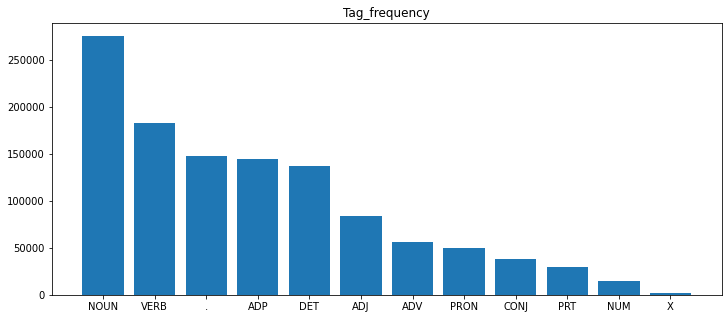

In [10]:
plt.figure(figsize=(12, 5))
plt.bar(tag_num.index, tag_num.values)
plt.title("Tag_frequency")
plt.show()

In [ ]:
word_num[:5]

the    69971
,      58334
.      49346
of     36412
and    28853
dtype: int64

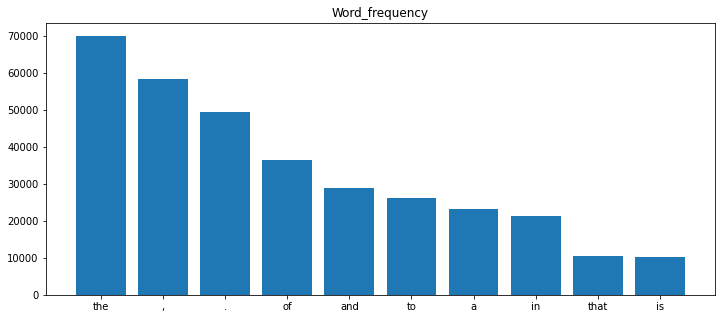

In [ ]:
plt.figure(figsize=(12, 5))
plt.bar(word_num.index[:10], word_num.values[:10])
plt.title("Word_frequency")
plt.show()

## Let's explore the corpus

In [ ]:
# How many words "cat" are there in the corpus?
[word for word in word_num.items() if word[0] == 'cat']

[('cat', 23)]

In [ ]:
# What is the most popular tag?
best_tag = tag_num.index[0]
best_tag

'NOUN'

In [ ]:
# What is the most popular word with the most popular tag?
words_with_best_tag = [word_tag[0] for word_tag in brown_tagged_words if word_tag[1] == best_tag]
best_words = pd.Series(nltk.FreqDist(words_with_best_tag)).sort_values(ascending=False)

best_word = best_words.index[0]
best_word

As working with the whole corpus may be expensive in terms of time, we will to work with one of the corpus categories during training.

Categories:

In [ ]:
brown.categories()

['adventure',
 'belles_lettres',
 'editorial',
 'fiction',
 'government',
 'hobbies',
 'humor',
 'learned',
 'lore',
 'mystery',
 'news',
 'religion',
 'reviews',
 'romance',
 'science_fiction']

We will only work with humor

In [144]:
brown_tagged_sents = brown.tagged_sents(tagset="universal", categories='humor')
# Приведем слова к нижнему регистру
my_brown_tagged_sents = []
for sent in brown_tagged_sents:
    my_brown_tagged_sents.append(list(map(lambda x: (x[0].lower(), x[1]), sent)))
my_brown_tagged_sents = np.array(my_brown_tagged_sents)

from sklearn.model_selection import train_test_split
train_sents, test_sents = train_test_split(my_brown_tagged_sents, test_size=0.1, random_state=0,)

<ipython-input-144-a2119df4a9f5>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  my_brown_tagged_sents = np.array(my_brown_tagged_sents)


In [145]:
len(train_sents)

51606

In [146]:
len(test_sents)

5734

### Maximum likelihood method for model training (Markov model)

* $\normalsize S = s_0, s_1, ..., s_N$ - скрытые состояния, то есть различные теги
* $\normalsize O = o_0, o_1, ..., o_M$ - различные слова
* $\normalsize a_{i,j} = p(s_j|s_i)$ - вероятность того, что, находясь в скрытом состоянии $s_i$, мы попадем в состояние $s_j$ (элемент матрицы $A$)
* $\normalsize b_{k,j}=p(o_k|s_j)$ - вероятность того, что при скрытом состоянии $s_j$ находится слово $o_k$(элемент матрицы $B$)

$$\normalsize x_t \in O, y_t \in S$$
$\normalsize (x_t, y_t)$ - слово и тег, стоящие на месте $t$ $\Rightarrow$ 
* $\normalsize X$ - последовательность слов
* $\normalsize Y$ - последовательность тегов

Требуется построить скрытую марковскую модель (class HiddenMarkovModel) и написать метод fit для настройки всех её параметров с помощью оценок максимального правдоподобия по размеченным данным (последовательности пар слово+тег):

- Вероятности переходов между скрытыми состояниями $p(y_t | y_{t - 1})$ посчитайте на основе частот биграмм POS-тегов.


- Вероятности эмиссий наблюдаемых состояний $p(x_t | y_t)$ посчитайте на основе частот "POS-тег - слово".


- Распределение вероятностей начальных состояний $p(y_0)$ задайте равномерным.

Пример $X = [x_0, x_1], Y = [y_0, y_1]$:<br><br>
$$p(X, Y) = p(x_0, x_1, y_0, y_1) = p(y_0) \cdot p(x_0, x_1, y_1 | y_0) = p(y_0) \cdot p(x_0 | y_0) \cdot
p(x_1, y_1 | x_0, y_0) = \\ = p(y_0) \cdot p(x_0 | y_0) \cdot p(y_1 | x_0, y_0) \cdot p(x_1 | x_0, y_0, y_1)
= (\text{в силу условий нашей модели}) = \\ = p(y_0) \cdot p(x_0 | y_0) \cdot p(y_1 | y_0) \cdot p(x_1 | y_1) \Rightarrow$$ <br>
Для последовательности длины $n + 1$:<br>
$$p(X, Y) = p(x_0 ... x_{n - 1}, y_0 ... y_{n - 1}) \cdot p(y_n | y_{n - 1}) \cdot p(x_n | y_n)$$

#### Алгоритм Витерби для применения модели


Требуется написать метод .predict для определения частей речи на тестовой выборке. Чтобы использовать обученную модель на новых данных, необходимо реализовать алгоритм Витерби. Это алгоритм динамиеского программирования, с помощью которого мы будем находить наиболее вероятную последовательность скрытых состояний модели для фиксированной последовательности слов:

$$ \hat{Y} = \arg \max_{Y} p(Y|X) = \arg \max_{Y} p(Y, X) $$

Пусть $\normalsize Q_{t,s}$ - самая вероятная последовательность скрытых состояний длины $t$ с окончанием в состоянии $s$. $\normalsize q_{t, s}$ - вероятность этой последовательности.
$$(1)\: \normalsize q_{t,s} = \max_{s'} q_{t - 1, s'} \cdot p(s | s') \cdot p(o_t | s)$$
$\normalsize Q_{t,s}$ можно восстановить по argmax-ам.

In [ ]:
class HiddenMarkovModel:    
    def __init__(self):
    
        pass
        
    def fit(self, train_tokens_tags_list):
        """
        train_tokens_tags_list: массив предложений пар слово-тег (выборка для train)
        """
        tags = [tag for sent in train_tokens_tags_list
                for (word, tag) in sent]
        words = [word for sent in train_tokens_tags_list
                 for (word, tag) in sent]

        tag_num = pd.Series(nltk.FreqDist(tags)).sort_index()
        word_num = pd.Series(nltk.FreqDist(words)).sort_values(ascending=False)
        
        self.tags = tag_num.index
        self.words = word_num.index
        
        A = pd.DataFrame({'{}'.format(tag) : [0] * len(tag_num) for tag in tag_num.index}, index=tag_num.index)
        B = pd.DataFrame({'{}'.format(tag) : [0] * len(word_num) for tag in tag_num.index}, index=word_num.index)
        
        for sent in train_tokens_tags_list:
            for i in range(len(sent)):
                B.loc[sent[i][0], sent[i][1]] += 1
                if len(sent) - 1 != i:
                    A.loc[sent[i][1], sent[i + 1][1]] += 1


        # Moving to probabilities
        
        # Normalizing by strings -- all possible tags
        A = A.divide(A.sum(axis=1), axis=0)
        
        # Normalizing by columns -- all possible words
        B = B / np.sum(B, axis=0)
        
        self.A = A
        self.B = B
        
        return self
        
    
    def predict(self, test_tokens_list):
        """
        test_tokens_list : массив предложений пар слово-тег (выборка для test)
        """
        predict_tags = OrderedDict({i : np.array([]) for i in range(len(test_tokens_list))})
        
        for i_sent in range(len(test_tokens_list)):
            
            current_sent = test_tokens_list[i_sent]
            len_sent = len(current_sent)
            
            q = np.zeros(shape=(len_sent + 1, len(self.tags)))
            q[0] = 1  # Starting state
            back_point = np.zeros(shape=(len_sent + 1, len(self.tags)))  # argmax
            
            for t in range(len_sent):
                
                # if we have not seen such a word in training, then instead of
                # it will be the most popular word with the most popular tag ('time')
                if current_sent[t] not in self.words:
                    current_sent[t] = 'time'
                    current_sent[t] = best_word
                    
                if current_sent[t] not in self.words:
                    continue
                
                # Choosing next tag with max
                for i_s in range(len(self.tags)):

                    s = self.tags[i_s]
                    
                    # Formula (1)
                    q[t + 1][i_s] = np.max(q[t] *
                        self.A.loc[:, s] * 
                        self.B.loc[current_sent[t], s])
                    
                    # argmax Formula (1)
                    
                    # argmax, to restore the tag sequence
                    
                    back_point[t + 1][i_s] = (q[t] * self.A.loc[:, s] * 
                        self.B.loc[current_sent[t],s]).reset_index()[s].idxmax()  # index
                    
            back_point = back_point.astype('int')
            
            # Printing tags in the real order
            back_tag = deque()
            current_tag = np.argmax(q[len_sent])
            for t in range(len_sent, 0, -1):
                back_tag.appendleft(self.tags[current_tag])
                current_tag = back_point[t, current_tag]
             
            predict_tags[i_sent] = np.array(back_tag)
        
        
        return predict_tags                 

In [ ]:
my_model = HiddenMarkovModel()
my_model.fit(train_sents);

Lets test the model on the following sentences.

- 'He can stay'
- 'a cat and a dog'
- 'I have a television'
- 'My favourite character'

In [ ]:
sents = [['He', 'can', 'stay'], ['a', 'cat', 'and', 'a', 'dog'], ['I', 'have', 'a', 'television'],
         ['My', 'favourite', 'character']]
my_model.predict(sents)


OrderedDict([(0, array(['NOUN', 'VERB', 'VERB'], dtype='<U4')),
             (1, array(['DET', 'NOUN', 'CONJ', 'DET', 'NOUN'], dtype='<U4')),
             (2, array(['NOUN', 'VERB', 'DET', 'NOUN'], dtype='<U4')),
             (3, array(['NOUN', 'NOUN', 'NOUN'], dtype='<U4'))])

For some words (e.g. `can`) we get a correct tagging: `VERB`.

For other words (e.g. `favourite`) we get an incorrect tagging: `NOUN`.

Let's compute accuracy on the test Brown corpus.

In [ ]:
def accuracy_score(model, sents):
    true_pred = 0
    num_pred = 0

    for sent in sents:
        tags = [tag for (word, tag) in sent]
        words = np.array([[word for (word, tag) in sent]])

        output = list(my_model.predict(words).values())[0]

        true_pred += sum(tags == output)
        num_pred += len(sent)
    print("Accuracy:", true_pred / num_pred * 100, '%')

In [ ]:
accuracy_score(my_model, test_sents)

Accuracy: 88.82847256549678 %


## DefaultTagger

What accuracy would be achieved if we predict any tag as the most popular tag in the train dataset (noun)?

In [ ]:
test_tags = [np.array([tag for (_, tag) in sent]) for sent in test_sents]
simplest_preds = [np.array(['NOUN' for _ in sent]) for sent in test_sents]

In [ ]:
true_pred = 0
num_pred = 0

for real_tags, pred_tags in zip(test_tags, simplest_preds):
    true_pred += sum(real_tags == pred_tags)
    num_pred += len(real_tags)
print("Accuracy:", true_pred / num_pred * 100, '%')

Accuracy: 20.217498764211566 %


## NLTK

What accuracy would be achieved with NLTK built in tagger?

In [ ]:
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize

In [ ]:
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

In [ ]:
true_pred = 0
num_pred = 0

for sent in test_sents:
    tags = [tag for (word, tag) in sent]
    words = [word for (word, tag) in sent]

    output_with_words = pos_tag(words, tagset='universal')
    output = np.array([tag for (word, tag) in output_with_words])

    true_pred += sum(tags == output)
    num_pred += len(sent)
print("Accuracy:", true_pred / num_pred * 100, '%')


Accuracy: 89.22392486406328 %


## BiLSTMTagger

### Data preparation

In [152]:
pos_data = [list(zip(*sent)) for sent in brown_tagged_sents]

In [ ]:
!pip install -U torch==1.8.0+cu111 torchtext==0.9.0 torchvision==0.9.0+cu111 torchaudio==0.8.0 -f https://download.pytorch.org/whl/torch_stable.html

# Reload environment
exit()

In [153]:
from torchtext.legacy.data import Field, BucketIterator
import torchtext

WORD = Field(lower=True)
TAG = Field(unk_token=None)

# Creating examples
examples = []
for words, tags in pos_data:
    examples.append(torchtext.legacy.data.Example.fromlist([list(words), list(tags)], fields=[('words', WORD), ('tags', TAG)]))

One of our examples:

In [154]:
print(vars(examples[0]))

{'words': ['the', 'fulton', 'county', 'grand', 'jury', 'said', 'friday', 'an', 'investigation', 'of', "atlanta's", 'recent', 'primary', 'election', 'produced', '``', 'no', 'evidence', "''", 'that', 'any', 'irregularities', 'took', 'place', '.'], 'tags': ['DET', 'NOUN', 'NOUN', 'ADJ', 'NOUN', 'VERB', 'NOUN', 'DET', 'NOUN', 'ADP', 'NOUN', 'ADJ', 'NOUN', 'NOUN', 'VERB', '.', 'DET', 'NOUN', '.', 'ADP', 'DET', 'NOUN', 'VERB', 'NOUN', '.']}


Now let's create the dataset

In [156]:
# кладем примеры в наш датасет
dataset = torchtext.legacy.data.Dataset(examples=examples, fields=[('words', WORD), ('tags', TAG)])

train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.1, 0.1])

print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 45872
Number of validation examples: 5734
Number of testing examples: 5734


In [240]:
WORD.build_vocab(train_data, min_freq=1)
TAG.build_vocab(train_data)

print(f"Unique tokens in source (ru) vocabulary: {len(WORD.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TAG.vocab)}")

print(WORD.vocab.itos[::200])
print(TAG.vocab.itos)

Unique tokens in source (ru) vocabulary: 44941
Unique tokens in target (en) vocabulary: 13
['<unk>', 'fact', 'economic', 'indeed', 'series', 'station', 'happy', 'assumed', 'besides', 'sleep', 'conduct', 'fundamental', 'depends', 'burned', 'relationships', 'sympathy', 'tied', 'shapes', 'muscles', 'dan', 'part-time', 'submarines', '28', 'binding', '1945', 'shipping', 'mexico', 'elegant', 'whites', 'memories', 'bees', 'objections', 'beating', 'locations', '1940', 'gaining', 'short-term', 'cigar', 'mahzeer', 'subsystems', 'charts', 'guarantee', 'pleasantly', 'two-story', 'cancel', 'flannagan', 'missionaries', 'sixty-one', 'absently', 'compelling', 'flashlight', 'macklin', 'radios', 'stunned', '5%', 'capone', 'downright', 'graphite', 'lowell', 'persistence', 'self-sustaining', 'treasures', 'abstracts', 'bordering', 'contributors', 'earthmen', "garth's", 'inexplicable', 'marksmanship', 'penned', 'remotely', 'softness', 'tribe', '1-a', 'amsterdam', 'blasphemous', 'chesapeake', 'cryptic', 'dov

In [241]:
print(vars(train_data.examples[9]))

{'words': ['a', 'second', 'twitched', 'his', 'shirtsleeve', ',', 'and', 'he', 'felt', 'a', 'brief', 'burn', 'on', 'his', 'upper', 'arm', '.'], 'tags': ['DET', 'ADJ', 'VERB', 'DET', 'NOUN', '.', 'CONJ', 'PRON', 'VERB', 'DET', 'ADJ', 'NOUN', 'ADP', 'DET', 'ADJ', 'NOUN', '.']}


Let's discover how long sentences are in the corpus.

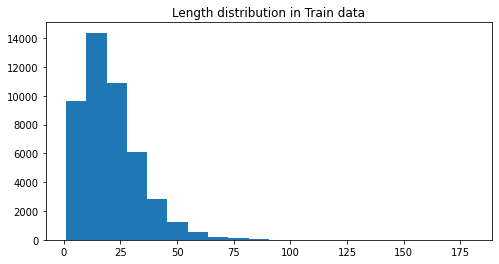

In [242]:
length = map(len, [vars(x)['words'] for x in train_data.examples])

plt.figure(figsize=[8, 4])
plt.title("Length distribution in Train data")
plt.hist(list(length), bins=20);

In [243]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [255]:
# We split into batches, sorting the data by length first
def _len_sort_key(x):
    return len(x.words)

BATCH_SIZE = 32

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

In [300]:
# Number of batches in each dataset
list(map(len, [train_iterator, valid_iterator, test_iterator]))

[1434, 180, 180]

### Build and train model

In [264]:
class LSTMTagger(nn.Module):

    def __init__(self, input_dim, emb_dim, hid_dim, output_dim, dropout, bidirectional=False):
        super().__init__()
        
  
        self.embeddings = nn.Embedding(input_dim, emb_dim)
        self.dropout = nn.Dropout(dropout)
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, bidirectional=bidirectional)

        self.tag = nn.Linear((1 + bidirectional) * hid_dim, output_dim)

    def forward(self, sent):
        
        #sent = [sent len, batch size] 
        
        embedded = self.dropout(self.embeddings(sent))

        output, _ = self.rnn(embedded)
        #output = [sent len, batch size, hid dim * n directions]

        prediction = self.tag(output)
    
        return prediction


In [284]:
# Model parameters
INPUT_DIM = len(WORD.vocab)
OUTPUT_DIM = len(TAG.vocab)

EMB_DIM = 300
HID_DIM = 256
DROPOUT = 0.4
BIDIRECTIONAL = True

model = LSTMTagger(
    INPUT_DIM, EMB_DIM, HID_DIM, OUTPUT_DIM, DROPOUT, BIDIRECTIONAL).to(device)

# Initializing model weights
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        
model.apply(init_weights);

LSTMTagger(
  (embeddings): Embedding(44941, 300)
  (dropout): Dropout(p=0.4, inplace=False)
  (rnn): LSTM(300, 256, bidirectional=True)
  (tag): Linear(in_features=512, out_features=13, bias=True)
)

In [285]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 14,631,753 trainable parameters


Training time!

In [286]:
PAD_IDX = TAG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        optimizer.zero_grad()
        
        output = model(batch.words.to(device))
        tags = batch.tags.to(device)
        
        #tags = [sent len, batch size]
        #output = [sent len, batch size, output dim]
        
        output = output.view(-1, output.shape[2])
        tags = tags.view(-1)
        
        #tags = [sent len * batch size]
        #output = [sent len * batch size, output dim]

        loss = criterion(output, tags)
        
        loss.backward()
        
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()
        
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            output = model(batch.words.to(device))
            tags = batch.tags.to(device)

            #tags = [sent len, batch size]
            #output = [sent len, batch size, output dim]

            output = output.view(-1, output.shape[2])
            tags = tags.view(-1)

            #tags = [sent len * batch size]
            #output = [sent len * batch size, output dim]

            loss = criterion(output, tags)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

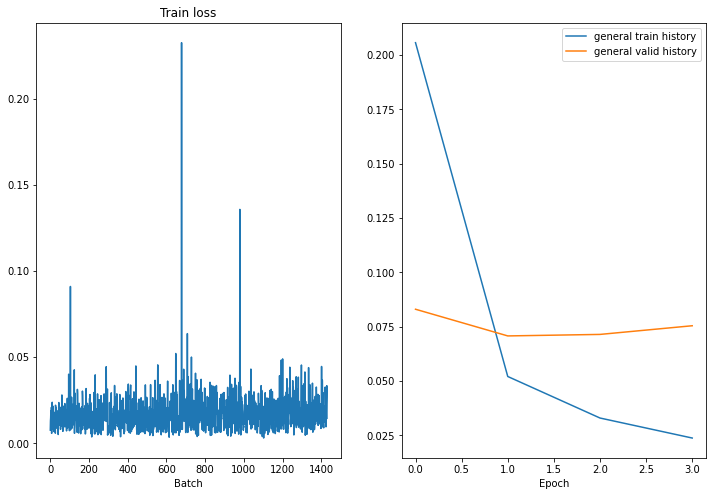

Epoch: 05 | Time: 1m 11s
	Train Loss: 0.017 | Train PPL:   1.017
	 Val. Loss: 0.082 |  Val. PPL:   1.085


In [287]:
import time
import math
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

train_history = []
valid_history = []

N_EPOCHS = 5
CLIP = 2

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-val-model.pt')

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [291]:
best_model = LSTMTagger(INPUT_DIM, EMB_DIM, HID_DIM, OUTPUT_DIM, DROPOUT, BIDIRECTIONAL).to(device)
best_model.load_state_dict(torch.load('best-val-model.pt'))

<All keys matched successfully>

### Evaluating the model

In [292]:
def accuracy_model(model, iterator):
    model.eval()
    
    true_pred = 0
    num_pred = 0
    
    with torch.no_grad():
        for i, batch in enumerate(iterator):

            words = batch.words.to(device).view(1, -1)
            tags = batch.tags.to(device).view(-1)

            output = model(words)
            
            #output = [sent len, batch size, output dim]
            output = torch.argmax(output, dim=2).view(-1)

            #output = [sent len, batch size]
            predict_tags = output.cpu().numpy()
            true_tags = tags.cpu().numpy()

            true_pred += np.sum((true_tags == predict_tags) & (true_tags != PAD_IDX))
            num_pred += np.prod(true_tags.shape) - (true_tags == PAD_IDX).sum()
        
    return round(true_pred / num_pred * 100, 3)

In [293]:
print("Accuracy:", accuracy_model(best_model, test_iterator), '%')

Accuracy: 93.073 %


Example of tagging

In [296]:
def print_tags(model, data):
    model.eval()
    
    with torch.no_grad():
        words, _ = data
        example = torch.LongTensor([WORD.vocab.stoi[elem] for elem in words]).unsqueeze(1).to(device)
        
        output = model(example).argmax(dim=-1).cpu().numpy()
        tags = [TAG.vocab.itos[int(elem)] for elem in output]

        for token, tag in zip(words, tags):
            print(f'{token:15s}{tag}')

In [297]:
print_tags(model, pos_data[-1])

From           NOUN
what           DET
I              NOUN
was            VERB
able           ADJ
to             ADP
gauge          NOUN
in             ADP
a              DET
swift          ADJ
,              .
greedy         ADJ
glance         NOUN
,              .
the            DET
figure         NOUN
inside         ADP
the            DET
coral-colored  ADJ
boucle         NOUN
dress          NOUN
was            VERB
stupefying     VERB
.              .
